In [1]:
! pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import packages
import dgl
import torch
import torch.nn.functional as F
import numpy as np
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv
from IPython.display import Latex
from sklearn.model_selection import train_test_split
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
'''
class BasicGraphModel(torch.nn.Module):

    def __init__(self, n_layers, input_size, hidden_size, output_size):
        super(BasicGraphModel, self).__init__()

        # Define GNN components
        self.convs = torch.nn.ModuleList()
        self.convs.append(GraphConv(input_size, hidden_size))
        for i in range(n_layers-1):
            self.convs.append(GraphConv(hidden_size, hidden_size))
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, g, x):
        # Message Passing -- Learn node representations via GCN
        for conv in self.convs[:-1]:
            x = conv(g, x)
            x = F.elu(x)
        x = self.convs[-1](g, x)
        # Readout -- average all node representations to get graph embedding
        g.ndata['h'] = x
        x = dgl.mean_nodes(g, 'h')
        # Apply linear layer to classify graph representation
        x = self.linear(x)
        return x
'''
class BasicGraphModel(torch.nn.Module):

    def __init__(self, n_layers, input_size, hidden_size, output_size):
        super(BasicGraphModel, self).__init__()

        # Define GNN components
        self.convs = torch.nn.ModuleList()
        self.convs.append(GraphConv(input_size, hidden_size))
        for i in range(n_layers-1):
            self.convs.append(GraphConv(hidden_size, hidden_size))
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, g, x):
        # Message Passing -- Learn node representations via GCN
        for conv in self.convs[:-1]:
            x = conv(g, x)
            x = F.leaky_relu(x)
        x = self.convs[-1](g, x)
        # Readout -- average all node representations to get graph embedding
        g.ndata['h'] = x
        x = dgl.mean_nodes(g, 'h')
        # Apply linear layer to classify graph representation
        x = self.linear(x)
        return x


In [4]:
dataset_proteins = dgl.data.TUDataset(name='PROTEINS')

# Add self loop to each graph
dataset_proteins.graph_lists = [dgl.add_self_loop(graph) for graph in dataset_proteins.graph_lists]

In [5]:
dataset_proteins[0]

(Graph(num_nodes=42, num_edges=204,
       ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'node_attr': Scheme(shape=(1,), dtype=torch.float64), 'node_labels': Scheme(shape=(1,), dtype=torch.int64)}
       edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}),
 tensor([0]))

In [6]:
print('Number of graph categories:', dataset_proteins.num_labels)
print('Dimension of nodes features', dataset_proteins[0][0].ndata['node_attr'].shape[1])

Number of graph categories: 2
Dimension of nodes features 1


In [7]:
# Split dataset into train, validation and test sets
train_sampler, val_sampler, test_sampler = dgl.data.utils.split_dataset(
        dataset_proteins, frac_list=[0.6, 0.2, 0.2], shuffle=True)

In [8]:
# batch graphs with GraphDataLoader
train_dataloader = GraphDataLoader(
        train_sampler, batch_size=5, drop_last=False)
val_dataloader = GraphDataLoader(
    val_sampler, batch_size=5, drop_last=False)
test_dataloader = GraphDataLoader(
    test_sampler, batch_size=5, drop_last=False)

In [12]:
def train_classif(model, loss_fcn, optimizer, train_dataloader, val_dataloader, num_epochs):
    model = model.double()
    model.train()

    for epoch in range(num_epochs):
        losses = []
        for batch, batched_graph in enumerate(train_dataloader):
            batched_graph, labels = batched_graph
            logits = model(batched_graph, batched_graph.ndata['node_attr'].double())
            loss = loss_fcn(logits, labels.T[0])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.mean(losses)

        if epoch % 5 == 0:
            print("Epoch {} | Loss: {:.4f}".format(epoch, loss_data))
            test_classif(model, loss_fcn, val_dataloader)

In [16]:
def test_classif(model, loss_fcn, dataloader):
    scores = []
    for batch, batched_graph in enumerate(dataloader):
        batched_graph, labels = batched_graph
        scores.append(
            evaluate_classif(model, batched_graph, labels, loss_fcn))
    mean_scores = np.mean(scores)
    print("Accuracy score: {:.4f}".format(mean_scores))

In [14]:
def evaluate_classif(model, batched_graph, labels, loss_fcn):
    model = model.double()
    model.eval()
    with torch.no_grad():
        output = model(batched_graph, batched_graph.ndata['node_attr'].double())

    labels = labels.T[0]
    loss = loss_fcn(output, labels)
    predict = output.argmax(dim=1)
    score = (labels == predict).sum().item() / len(labels)

    return score

In [17]:
# Store features
n_features, n_classes = dataset_proteins[0][0].ndata['node_attr'].shape[1], \
    dataset_proteins.num_labels
hidden_size = 64

# Define model, loss function and optimizer
model = BasicGraphModel(n_layers=5, input_size=n_features,
                        hidden_size=hidden_size, output_size=n_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fcn = torch.nn.CrossEntropyLoss()

# Train and test
train_classif(model, loss_fcn, optimizer,
        train_dataloader, val_dataloader, num_epochs=150)
test_classif(model, loss_fcn, test_dataloader)


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 0 | Loss: 0.6940
Accuracy score: 0.5889
Epoch 5 | Loss: 0.6780
Accuracy score: 0.5889
Epoch 10 | Loss: 0.6770
Accuracy score: 0.5889
Epoch 15 | Loss: 0.6796
Accuracy score: 0.5889
Epoch 20 | Loss: 0.6757
Accuracy score: 0.5889
Epoch 25 | Loss: 0.6755
Accuracy score: 0.5889
Epoch 30 | Loss: 0.6773
Accuracy score: 0.5889
Epoch 35 | Loss: 0.6764
Accuracy score: 0.5889
Epoch 40 | Loss: 0.6707
Accuracy score: 0.5889
Epoch 45 | Loss: 0.6489
Accuracy score: 0.6511
Epoch 50 | Loss: 0.6391
Accuracy score: 0.6644
Epoch 55 | Loss: 0.6360
Accuracy score: 0.6600
Epoch 60 | Loss: 0.6342
Accuracy score: 0.6556
Epoch 65 | Loss: 0.6334
Accuracy score: 0.6556
Epoch 70 | Loss: 0.6325
Accuracy score: 0.6600
Epoch 75 | Loss: 0.6321
Accuracy score: 0.6600
Epoch 80 | Loss: 0.6329
Accuracy score: 0.6600
Epoch 85 | Loss: 0.6308
Accuracy score: 0.6644
Epoch 90 | Loss: 0.6321
Accuracy score: 0.6644
Epoch 95 | Loss: 0.6295
Accuracy score: 0.6644
Epoch 100 | Loss: 0.6291
Accuracy score: 0.6600
Epoch 105 | Lo

In [51]:
proteins_nx_graphs = [dgl.remove_self_loop(g).to_networkx() for g in dataset_proteins.graph_lists]
proteins_nx_node_attributes = [list(dataset_proteins[i][0].ndata['node_attr'].numpy().flatten()) for i in range(len(proteins_nx_graphs))]

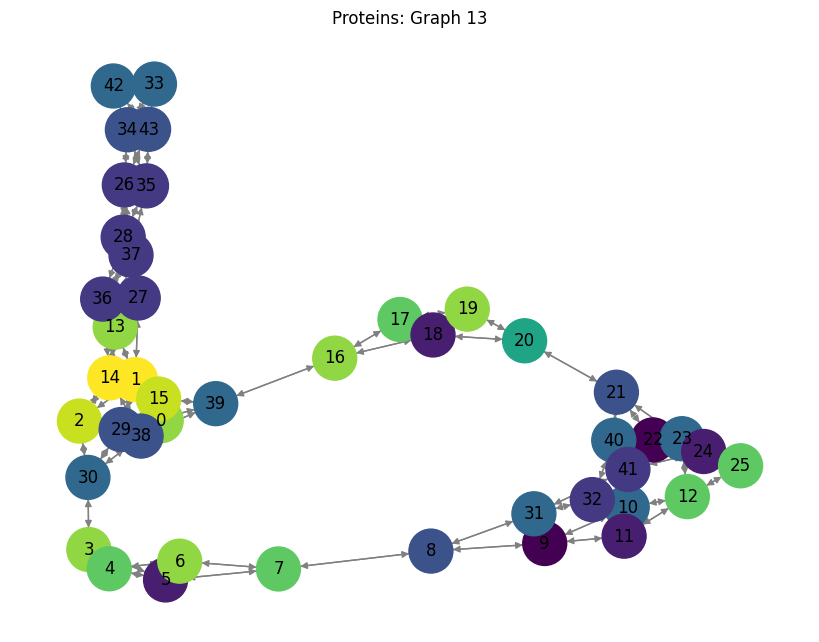

In [224]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(nx_graph_list, node_attributes_list, nx_graph_index, title=None):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(nx_graph_list[nx_graph_index], seed=42)
    nx.draw(nx_graph_list[nx_graph_index], pos, with_labels=True, node_color=node_attributes_list[nx_graph_index], edge_color='gray', node_size=1000)
    if title:
        plt.title(title)
    plt.show()

# Visualize the first graph from the ENZYMES dataset
nx_graph_index = 13
visualize_graph(proteins_nx_graphs,proteins_nx_node_attributes,nx_graph_index, title='Proteins: Graph '+str(nx_graph_index))

## GAE Implementation of Protein 

In [487]:
import torch
import torch.nn as nn
import torch.optim as optim
import dgl
from dgl.nn import GraphConv
from sklearn.model_selection import train_test_split
import numpy as np
from dgl.data import TUDataset
from torch.utils.data import Subset
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
import networkx as nx
import matplotlib.pyplot as plt


from dgl.nn import GraphConv
# Define the VGAE model
class Encoder(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(Encoder, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_feats)
        self.mean = GraphConv(hidden_feats, out_feats)
        self.logvar = GraphConv(hidden_feats, out_feats)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, graph, features):
        h = self.conv1(graph, features)
        mu, logvar = self.mean(graph,h), self.logvar(graph,h)
        z = self.reparameterize(mu, logvar)
        return  mu, logvar, z

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, out_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.lin1 = nn.Linear(latent_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.adjacency = nn.Linear(hidden_dim, out_dim)
        self.node_attributes = nn.Linear(hidden_dim,1) 
        
    def forward(self, z):
        h = F.relu(self.lin1(z))
        h = F.relu(self.lin2(h))
        node_attr_hat = torch.round(F.sigmoid(self.node_attributes(h))*60)  # Generate node attributes       
        h = self.adjacency(h)
        h = torch.mm(h, h.t())        
        adj_hat = torch.round(F.sigmoid(h)-0.4)
        adj_hat = torch.minimum(adj_hat + torch.eye(self.out_dim),torch.ones_like(adj_hat)) 
        return adj_hat, node_attr_hat

In [492]:
def train_gen(encoder, decoder, g, features, adj_orig, optimizer, criterion_adj,criterion_attr):
    attributes_unique = np.array([-538., -345., -344., -134., -125.,  -96.,    1.,    2.,    3., 4.,    5.,    6.,    7.,    8.,    9.,   10.,   11.,   12., 13.,   14.,   15.,   16.,   17.,   18.,   19.,   20.,   21., 22.,   23.,   24.,   25.,   26.,   27.,   28.,   29.,   30., 31.,   32.,   33.,   34.,   35.,   36.,   37.,   38.,   39., 41.,   42.,   47.,   61.,   63.,   73.,   74.,   75.,   82., 104.,  353.,  355.,  360.,  558.,  797.,  798.])
    true_attr = torch.tensor([np.where(attributes_unique==n) for n in features])

    encoder.train()
    decoder.train()
    optimizer.zero_grad()

    mu, logvar, z = encoder(g, features)
    adj_pred, nodes_attr = decoder(z)
    features = features.flatten().numpy()
    true_attr = torch.tensor([np.where(attributes_unique==n) for n in features.tolist()],dtype=torch.float).view(-1,1)

    encoder_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.maximum(logvar.exp(),1e-7*torch.ones_like(logvar)))
    decoder_loss = criterion_adj(adj_pred,adj_orig) #+ criterion_attr(nodes_attr,true_attr)
    loss = encoder_loss #+ decoder_loss
    loss.backward()
    optimizer.step()

    return loss.item()

def evaluate_gen(encoder, decoder, g, features,adj_orig, criterion_adj,criterion_attr):
    attributes_unique = np.array([-538., -345., -344., -134., -125.,  -96.,    1.,    2.,    3., 4.,    5.,    6.,    7.,    8.,    9.,   10.,   11.,   12., 13.,   14.,   15.,   16.,   17.,   18.,   19.,   20.,   21., 22.,   23.,   24.,   25.,   26.,   27.,   28.,   29.,   30., 31.,   32.,   33.,   34.,   35.,   36.,   37.,   38.,   39., 41.,   42.,   47.,   61.,   63.,   73.,   74.,   75.,   82., 104.,  353.,  355.,  360.,  558.,  797.,  798.])
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        mu, logvar, z = encoder(g, features)
        adj_pred, nodes_attr = decoder(z)
        features = features.flatten().numpy()
        true_attr = torch.tensor([np.where(attributes_unique==n) for n in features.tolist()],dtype=torch.float).view(-1,1)

        encoder_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.maximum(logvar.exp(),1e-7*torch.ones_like(logvar)))
        decoder_loss = criterion_adj(adj_pred,adj_orig) #+ criterion_attr(nodes_attr,true_attr)
        loss = encoder_loss #+ decoder_loss
        return loss.item()

In [493]:
# Prepare the dataset and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_proteins = TUDataset(name='PROTEINS')
dataset_proteins.graph_lists = [dgl.add_self_loop(graph) for graph in dataset_proteins.graph_lists]

# Get the indices of the graphs with label 1
idx = [i for i in range(len(dataset_proteins)) if dataset_proteins[i][1] == 1]

# Create a Subset containing only the graphs with label 1
subset_enzymes = Subset(dataset_proteins, idx)
subset_enzymes_graph_list = [dataset_proteins.graph_lists[i] for i in idx]

# Set parameters
graph, _ = subset_enzymes[0]
num_node_features = graph.ndata['node_attr'].shape[1]
in_feats = num_node_features
hidden_feats = 64
out_feats = 32
num_nodes_out = in_feats
lr = 0.001
epochs = 100

# Prepare the dataset
train_dataset, test_dataset = train_test_split(subset_enzymes_graph_list, test_size=0.1, random_state=42)
train_graphs = [graph.to(device) for graph in train_dataset]
test_graphs = [graph.to(device) for graph in test_dataset]

# Initialize the models and optimizer
encoder = Encoder(in_feats, hidden_feats, out_feats).to(device)
decoder = Decoder(out_feats,hidden_feats,num_nodes_out).to(device)
model = nn.Sequential(encoder, decoder).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion_adj = nn.BCEWithLogitsLoss()
criterion_attr = nn.MSELoss()

# Train and evaluate the GAE
for epoch in range(epochs):
    train_losses = []
    for g in train_graphs:
        features = g.ndata['node_attr'].float().to(device)
        adj_orig = torch.Tensor(g.adjacency_matrix().to_dense()).to(device)
        train_loss = train_gen(encoder, decoder, g, features, adj_orig, optimizer, criterion_adj,criterion_attr)
        train_losses.append(train_loss)

    train_loss_mean = np.mean(train_losses)

    test_losses = []
    for g in test_graphs:
        features = g.ndata['node_attr'].float().to(device)
        adj_orig = torch.Tensor(g.adjacency_matrix().to_dense()).to(device)
        test_loss = evaluate_gen(encoder, decoder, g, features, adj_orig, criterion_adj,criterion_attr)
        test_losses.append(test_loss)

    test_loss_mean = np.mean(test_losses)

    print(f'Epoch: {epoch + 1}, Train Loss: {train_loss_mean:.4f}, Test Loss: {test_loss_mean:.4f}')

Epoch: 1, Train Loss: 26.5991, Test Loss: 0.3343
Epoch: 2, Train Loss: 0.0991, Test Loss: 0.2437
Epoch: 3, Train Loss: 0.1782, Test Loss: 0.5301
Epoch: 4, Train Loss: 0.0661, Test Loss: 0.2199
Epoch: 5, Train Loss: 0.1188, Test Loss: 0.4357
Epoch: 6, Train Loss: 0.1060, Test Loss: 0.5188
Epoch: 7, Train Loss: 0.3979, Test Loss: 2.0677
Epoch: 8, Train Loss: 0.0618, Test Loss: 0.0698
Epoch: 9, Train Loss: 0.3670, Test Loss: 2.1834
Epoch: 10, Train Loss: 0.3636, Test Loss: 2.4147
Epoch: 11, Train Loss: 0.1507, Test Loss: 0.4579
Epoch: 12, Train Loss: 0.0852, Test Loss: 0.2302
Epoch: 13, Train Loss: 0.4779, Test Loss: 2.6709
Epoch: 14, Train Loss: 0.1908, Test Loss: 2.7017
Epoch: 15, Train Loss: 0.2830, Test Loss: 2.6893
Epoch: 16, Train Loss: 0.2233, Test Loss: 0.5767
Epoch: 17, Train Loss: 0.0848, Test Loss: 0.4572
Epoch: 18, Train Loss: 0.1370, Test Loss: 1.0788
Epoch: 19, Train Loss: 0.1694, Test Loss: 0.4630
Epoch: 20, Train Loss: 0.1125, Test Loss: 1.1773
Epoch: 21, Train Loss: 0.446

In [490]:
def create_graph_from_reconstruction(adj_pred, node_attr_hat):
    # Convert adjacency matrix to edgelist
    edges = torch.nonzero(adj_pred)
    src, dst = edges[:, 0], edges[:, 1]

    # Create DGL graph from edgelist
    g = dgl.graph((src, dst))

    # Add self loops
    g = dgl.add_self_loop(g)

    nx_graph = dgl.remove_self_loop(g).to_networkx()
    isolates = list(nx.isolates(nx_graph))
    nx_graph.remove_nodes_from(isolates)

    nx_node_attributes = node_attr_hat.numpy().flatten()
    nx_node_attributes = np.delete(nx_node_attributes, isolates, axis=0)
    g= dgl.from_networkx(nx_graph)

    # Set node_labels and _ID
    g.ndata['_ID'] = torch.arange(g.number_of_nodes()).view(-1)

    # Add node attributes to the graph
    g.ndata['node_attr'] = node_attr_hat

    # Set node_labels and _ID
    g.ndata['node_labels'] = torch.arange(g.number_of_nodes()).view(-1,1)

    # Set the edge IDs
    g.edata['_ID'] = torch.arange(g.number_of_edges()).view(-1)

    return g

torch.Size([10, 10]) torch.Size([10, 1])


Text(0.5, 1.0, 'Generated Protein by VGAE')

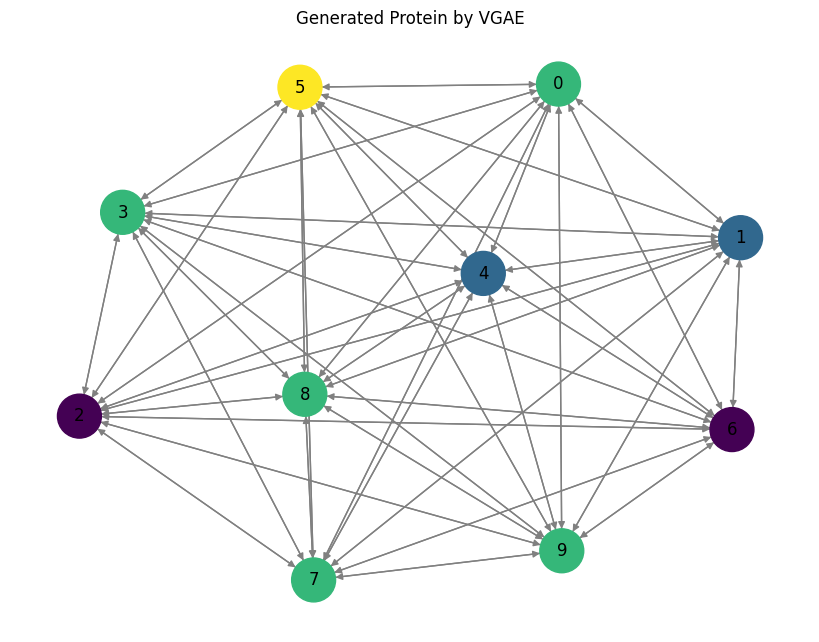

In [491]:
attributes_unique = np.array([-538., -345., -344., -134., -125.,  -96.,    1.,    2.,    3., 4.,    5.,    6.,    7.,    8.,    9.,   10.,   11.,   12., 13.,   14.,   15.,   16.,   17.,   18.,   19.,   20.,   21., 22.,   23.,   24.,   25.,   26.,   27.,   28.,   29.,   30., 31.,   32.,   33.,   34.,   35.,   36.,   37.,   38.,   39., 41.,   42.,   47.,   61.,   63.,   73.,   74.,   75.,   82., 104.,  353.,  355.,  360.,  558.,  797.,  798.])
random_sample = np.random.choice(np.array(dataset_proteins.graph_lists))
random_sample = dataset_proteins.graph_lists[2]

with torch.no_grad():
  features = random_sample.ndata['node_attr'].float().to(device)
  mu, logvar, z = encoder(random_sample, features)
  adj_pred, nodes_attr = decoder(z)
  adj_pred = torch.minimum(adj_pred + torch.eye(adj_pred.shape[0]),torch.ones_like(adj_pred)) 

  nodes_attr = torch.tensor(attributes_unique[nodes_attr.detach().numpy().astype(int)],dtype=torch.double)
  
  print(adj_pred.shape, nodes_attr.shape)
  generated_protein = create_graph_from_reconstruction(adj_pred, nodes_attr)



nx_generated_protein = dgl.remove_self_loop(generated_protein).to_networkx()
isolates = list(nx.isolates(nx_generated_protein))
nx_generated_protein.remove_nodes_from(isolates)



nx_node_attributes_generated_protein = list(generated_protein.ndata['node_attr'].numpy().flatten())
nx_node_attributes_generated_protein = np.delete(nx_node_attributes_generated_protein, isolates, axis=0)
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(nx_generated_protein, seed=42)
nx.draw(nx_generated_protein, pos, with_labels=True, node_color=nx_node_attributes_generated_protein, edge_color='gray', node_size=1000)
plt.title("Generated Protein by VGAE")



In [ ]:
from dgl.nn import GraphConv


class GraphConvModel(torch.nn.Module):
    """
    Base model to perform aggregation of latent variables either by mean or by max
    """

    def _init_(self, n_layers, input_size, hidden_size, output_size, agg):
        super(GraphConvModel, self)._init_()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GraphConv(input_size, hidden_size))
        for i in range(n_layers-1):
            self.convs.append(GraphConv(hidden_size, hidden_size))
        self.linear = torch.nn.Linear(hidden_size, output_size)
        self.agg = dgl.mean_nodes if agg=="mean" else dgl.max_nodes

    def forward(self, g, x):
        # Message Passing
        for conv in self.convs[:-1]:
            x = F.elu(conv(g, x))
        x = self.convs[-1](g, x)
        # Readout 
        g.ndata['h'] = x
        x = self.agg(g, 'h')
        x = self.linear(x)
        return x

In [258]:
from sklearn.model_selection import train_test_split
model = ClassifierModel(args).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()
best_performance = torch.load('model_hgpsl_pool.pt')
model.load_state_dict(best_performance)

Graph(num_nodes=42, num_edges=890,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'node_attr': Scheme(shape=(1,), dtype=torch.float64), 'node_labels': Scheme(shape=(1,), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})

In [75]:
#load untrained generator. Generate 1000 examples load into dataloader
gen = Generator(input_dim=3, hidden_dim=128, output_dim=32).to(device)
gen.load_state_dict(torch.load("generator.pth", map_location='cpu'))
generated_graph=generate_datasets(gen,1000)
test_loader = DataLoader(generated_graph, batch_size=10, shuffle=False)
#SOTA model evaluate on generated graphs
model.eval()
ones = 0
for data in test_loader:
    data = data.to(device)
    with torch.no_grad():
        out = model(data)
    pred = out.argmax(dim=1)
    ones += (pred).sum().item()
print(f"Percentage of generated graphs recognized as enzymes by SOTA classifier on protein dataset: {ones/10}%")